# Learning Dynamics with VAEs

Bayesian inference often struggles in high-dimensional spaces (not with RxInfer.jl, it actually happens rarely) - a challenge known as the "curse of dimensionality." 
There are several approaches to tackle this problem, among them:

1. **Hierarchical models** - Breaking down complex problems into nested, [simpler components](https://reactivebayes.github.io/GraphPPL.jl/stable/nested_models/)
2. **Compromise approaches** - Being "partially Bayesian" by combining Bayesian and non-fully Bayesian methods

In this notebook, we explore the compromise approach. We'll use a Variational Autoencoder (VAE) to learn a low-dimensional latent representation of MNIST digits, and then perform Bayesian inference on the dynamics of rotating digits in this latent space.

> **Note:** This is a simple example with simplified data that serves as a template for more interesting applications.
> 
> Throughout this demonstration we will use CPU for computation; however, the model is fully GPU compatible. See [AutoEncoderToolkit.jl](https://mrazomej.github.io/AutoEncoderToolkit.jl/stable/) for more details.

This demonstrates how we can leverage the strengths of both worlds:
- VAEs for efficient dimensionality reduction (non-fully Bayesian)
- Bayesian inference for learning dynamics in the resulting low-dimensional space

Let's see how this hybrid approach allows us to model image transformations in the latent space!

In [1]:
import AutoEncoderToolkit
import Flux
using MLDatasets: MNIST
import JLD2
using Plots
using Statistics
using RxInfer, ReactiveMP, LinearAlgebra

## Part 1: Creating a Dataset of Rotating Digits
First, we need data to work with. Instead of using static MNIST digits, we'll create a dataset
of rotating digits. This will give us a clear transformation to model in the latent space.

We'll select a few examples of digits 0 and 1, then generate multiple rotated versions of each.

In [2]:
"""
    generate_rotated_sequence(image, n_frames=36, max_angle=360)

Generate a sequence of rotated versions of an input image.
Returns the sequence of rotated images.
"""
function generate_rotated_sequence(image, n_frames=36, max_angle=360)
    img_2d = image[:, :, 1, 1]
    
    # Get image dimensions
    height, width = size(img_2d)
    
    # Create array to store rotated images
    rotated_images = []
    
    for i in 1:n_frames
        # Calculate rotation angle for this frame
        angle = (i-1) * max_angle / n_frames
        
        # Create rotation matrix
        rotation = [cosd(angle) -sind(angle); sind(angle) cosd(angle)]
        
        # Create empty image for the rotated result
        rotated = zeros(Float32, height, width)
        
        # Center of the image
        center_y, center_x = (height+1)/2, (width+1)/2
        
        # Apply rotation to each pixel
        for y in 1:height, x in 1:width
            # Convert to coordinates relative to center
            y_centered = y - center_y
            x_centered = x - center_x
            
            # Apply rotation
            new_coords = rotation * [x_centered, y_centered]
            
            # Convert back to image coordinates
            new_x = round(Int, new_coords[1] + center_x)
            new_y = round(Int, new_coords[2] + center_y)
            
            # Check if the new coordinates are within bounds
            if 1 <= new_x <= width && 1 <= new_y <= height
                rotated[y, x] = img_2d[new_y, new_x]
            end
        end
        
        # Store the rotated image
        push!(rotated_images, rotated)
    end
    
    return rotated_images
end

generate_rotated_sequence

In order to download datasets without having to manually confirm the download, we can set to true the `DATADEPS_ALWAYS_ACCEPT` environmental variable. Read more about MLDatasets.jl [here](https://juliaml.github.io/MLDatasets.jl/stable/).

In [3]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = true

true

In [4]:
"""
    create_rotated_mnist_dataset(n_samples_per_digit=10, n_rotations=36)

Create a dataset of rotated MNIST digits (0s and 1s).
Returns the dataset and labels.
"""
function create_rotated_mnist_dataset(n_samples_per_digit=10, n_rotations=36)
    # Load MNIST data
    train_dataset = MNIST(split=:train)
    
    # Find indices of 0s and 1s
    indices_0 = findall(x -> x == 0, train_dataset.targets)
    indices_1 = findall(x -> x == 1, train_dataset.targets)
    
    # Select a subset of each digit
    selected_indices_0 = indices_0[1:n_samples_per_digit]
    selected_indices_1 = indices_1[1:n_samples_per_digit]
    
    # Combine indices
    selected_indices = vcat(selected_indices_0, selected_indices_1)
    
    # Create arrays to store rotated images and labels
    rotated_images = []
    rotated_labels = []
    
    # For each selected digit
    for (i, idx) in enumerate(selected_indices)
        # Get the original image
        original = Float32.(reshape(train_dataset.features[:, :, idx], 28, 28))
        
        # Get the label
        label = train_dataset.targets[idx]
        
        # Generate rotated versions
        rotations = generate_rotated_sequence(original, n_rotations)
        
        # Add to dataset
        for rotated in rotations
            push!(rotated_images, rotated)
            push!(rotated_labels, label)
        end
    end
    
    # Convert to arrays
    X = zeros(Float32, 28, 28, 1, length(rotated_images))
    for i in 1:length(rotated_images)
        X[:, :, 1, i] = rotated_images[i]
    end
    
    y = rotated_labels
    
    # we will use a binarized version of the MNIST datase
    threshold = 0.5 * maximum(X)
    X = Float32.(X .> threshold)
    
    return X, y
end

create_rotated_mnist_dataset

In [5]:
# Create rotated MNIST dataset
println("Creating rotated MNIST dataset...")
n_samples_per_digit = 10  # Number of original digits to use
n_rotations = 36  # Number of rotations per digit

rotated_train_data, rotated_train_labels = create_rotated_mnist_dataset(n_samples_per_digit, n_rotations)
println("Rotated dataset created with $(size(rotated_train_data, 4)) images")

# Create an animation of sample rotated digits
sample_indices = rand(1:n_samples_per_digit*2, 5)  # 5 random digits from our dataset
sample_animation = @animate for angle_idx in 1:n_rotations
    # Create a plot with 5 random digits at the same rotation angle
    p = plot(layout=(1, 5), size=(1000, 200))
    for (i, digit_idx) in enumerate(sample_indices)
        # Calculate the index in the full dataset
        idx = (digit_idx-1) * n_rotations + angle_idx
        # Use binary colors (white background, black digits)
        heatmap!(p, rotated_train_data[:, :, 1, idx], 
                color=[:black, :white], 
                colorbar=false,
                title="Digit: $(rotated_train_labels[idx])", 
                subplot=i, axis=false)
    end
    plot!(p, title="Rotation: $(round((angle_idx-1)*360/n_rotations, digits=1))°")
end

# Save as GIF with 10 frames per second
gif(sample_animation, "rotated_digits_samples.gif", fps=10, show_msg=false);

Creating rotated MNIST dataset...
Rotated dataset created with 720 images


![](rotated_digits_samples.gif)

## Part 2: Building the VAE Model

Now we'll define our Variational Autoencoder. The VAE will learn to compress the high-dimensional
image data (28×28 = 784 dimensions) into a much lower-dimensional latent space (just 2 dimensions in this example).

This is the "non-Bayesian" part of our approach - we're using a neural network for dimensionality
reduction rather than a fully Bayesian model, which would be computationally intractable for
high-dimensional image data.

In [6]:
"""
    create_vae(n_latent=2, n_channels_init=32)

Create a VAE model with convolutional encoder and decoder.
Returns the VAE model with a 2D latent space by default.
"""
function create_vae(n_latent=2, n_channels_init=32)
    # Define convolutional layers for encoder
    conv_layers = Flux.Chain(
        Flux.Conv((4, 4), 1 => n_channels_init, Flux.relu; stride=2, pad=1),
        Flux.Conv((4, 4), n_channels_init => n_channels_init * 2, Flux.relu; stride=2, pad=1),
        AutoEncoderToolkit.Flatten(),
        Flux.Dense(n_channels_init * 2 * 7 * 7 => 256, Flux.relu),
        Flux.Dense(256 => 256, Flux.relu),
    )

    # Define layers for μ and log(σ)
    μ_layer = Flux.Dense(256, n_latent, Flux.identity)
    logσ_layer = Flux.Dense(256, n_latent, Flux.identity, bias=fill(-1.0f0, n_latent))

    # Build encoder
    encoder = AutoEncoderToolkit.JointGaussianLogEncoder(conv_layers, μ_layer, logσ_layer)

    # Define deconvolutional layers for decoder
    deconv_layers = Flux.Chain(
        Flux.Dense(n_latent => 256, Flux.identity),
        Flux.Dense(256 => 256, Flux.relu),
        Flux.Dense(256 => n_channels_init * 2 * 7 * 7, Flux.relu),
        AutoEncoderToolkit.Reshape(7, 7, n_channels_init * 2, :),
        Flux.ConvTranspose((4, 4), n_channels_init * 2 => n_channels_init, Flux.relu; stride=2, pad=1),
        Flux.ConvTranspose((4, 4), n_channels_init => 1, x -> Flux.sigmoid_fast(x * 5.0); stride=2, pad=1),
    )

    # Define decoder - use BernoulliDecoder for binarized data
    decoder = AutoEncoderToolkit.BernoulliDecoder(deconv_layers)

    # Define VAE model
    vae = encoder * decoder |> Flux.cpu
    
    return vae
end;

## Part 3: Training the VAE

Now we'll train the VAE on our rotated digit dataset. The VAE learns to:
1. Encode images into a 2D latent space (encoder)
2. Decode points from the latent space back to images (decoder)

During training, the VAE balances two objectives:
- Reconstruction accuracy (how well it can recreate the input images)
- Regularization of the latent space (ensuring it has a well-behaved distribution)

In [7]:
"""
    train_vae(vae, train_data; n_epoch=50, batch_size=64, learning_rate=1e-3)

Train a VAE model on the provided data.
Returns the trained model and training metrics.
"""
function train_vae(vae, train_data; n_epoch=50, batch_size=64, learning_rate=1e-3)
    # Create data loader
    train_loader = Flux.DataLoader(train_data, batchsize=batch_size, shuffle=true)
    
    # Setup optimizer
    opt_vae = Flux.Train.setup(Flux.Optimisers.Adam(learning_rate), vae)
    
    # Initialize arrays to save metrics
    train_losses = Array{Float32}(undef, n_epoch)
    
    # Loop through epochs
    for epoch in 1:n_epoch
        batch_losses = Float32[]
        
        # Calculate β value with annealing scheme
        β_value = epoch <= 15 ? 0.1f0 + (epoch - 1) / 15 * 0.9f0 : 1.0f0
        
        # Loop through batches
        for (i, x) in enumerate(train_loader)
            # Train VAE with current β value (doesn't return a value)
            AutoEncoderToolkit.VAEs.train!(vae, x, opt_vae; loss_kwargs=(β=β_value,))
            
            # Calculate loss separately
            batch_loss = AutoEncoderToolkit.VAEs.loss(vae, x; β=β_value)
            push!(batch_losses, batch_loss)
            
            # Print progress for every 10 batches
            if i % 10 == 0
                println("Epoch: $epoch/$n_epoch | Batch: $i/$(length(train_loader)) | Loss: $(round(mean(batch_losses), digits=4))")
            end
        end
        
        # Record average loss for epoch
        train_losses[epoch] = mean(batch_losses)
        
        # Print epoch summary
        println("Epoch $epoch/$n_epoch completed | Avg Loss: $(round(train_losses[epoch], digits=4))")
    end
    
    return vae, train_losses
end

train_vae

In [8]:
# # Create and train the VAE model on the rotated dataset
# # We will skip the training step within the notebook and will load the pre-trained model instead, feel free to uncomment the following lines to train the model yourself.
# println("Creating VAE model...")
# vae = create_vae()

# println("Training VAE on rotated MNIST dataset...")
# vae, losses = train_vae(vae, rotated_train_data, n_epoch=100)

# # Save the trained model parameters
# model_params = Dict()
# for (i, p) in enumerate(Flux.params(vae))
#     model_params["param_$i"] = Flux.cpu(p)  # Move to CPU before saving
# end

# # Save the parameters dictionary
# JLD2.save("rotated_mnist_vae_params.jld2", model_params)
# println("Model parameters saved to: rotated_mnist_vae_params.jld2")

# # Plot training loss
# loss_plot = plot(losses, title="VAE Training Loss (Rotated MNIST)", xlabel="Epoch", ylabel="Loss", 
#                  legend=false, linewidth=2, color=:blue)

In [9]:
# Create an empty VAE with the same architecture as the one you saved
function load_vae(filepath; n_latent=2, n_channels_init=32)
    # Create a new VAE with the same architecture
    vae = create_vae(n_latent, n_channels_init)
    
    # Load the saved parameters
    model_params = JLD2.load(filepath)
    
    # Get the parameters of the current model
    ps = Flux.params(vae)
    
    # Replace the parameters with the loaded ones
    for (i, p) in enumerate(ps)
        param_key = "param_$i"
        if haskey(model_params, param_key)
            # Copy values from saved parameters to the model
            copyto!(p, model_params[param_key])
        else
            @warn "Parameter $param_key not found in saved model"
        end
    end
    
    return vae
end

vae = load_vae("rotated_mnist_vae_params.jld2");

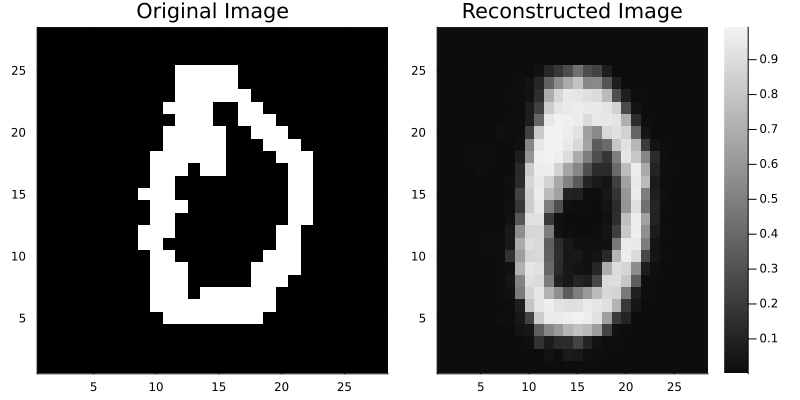

In [10]:
# Display original and reconstructed images
img = rotated_train_data[:, :, :, 42]
p1 = heatmap(img[:, :, 1, 1] |> Flux.cpu, color=[:black, :white], colorbar=false, title="Original Image")
# Reshape to add channel dimension (H×W → H×W×C) for network input
encoded_img = vae.encoder(reshape(img, size(img)..., 1))
# p represents pixel-wise probabilities (Bernoulli parameters) since we're using binarized images
decoded_img = vae.decoder(encoded_img.μ)
p2 = heatmap(decoded_img.p[:, :, 1, 1], color=:grays, title="Reconstructed Image")
display(plot(p1, p2, layout=(1, 2), size=(800, 400)))

## Part 4: Integrating VAE with RxInfer for Bayesian Inference

Now we come to the "Bayesian" part of our approach. We'll use RxInfer to perform Bayesian inference on the dynamics of rotating digits in the latent space.

First, we need to create a custom node that connects our VAE to the RxInfer framework. This is really [simple](https://docs.rxinfer.com/stable/manuals/customization/custom-node/), we just need to define a node and a couple of rules. Usually defining rules can be tricky, but in the case of a VAE it becomes very easy: the backward rule from observations to latent space is our encoder, and the forward rule from latent space to observations is our decoder.

In [11]:
# Create a VAE wrapper to help with RxInfer integration
struct VAENode end

# Meta struct to store the VAE model for use in message passing rules
struct VAEMeta{F}
    vae::F
end

# Define a custom VAE node for RxInfer
@node VAENode Stochastic [out, x]

# Define the backward message passing rule (z ← out)
@rule VAENode(:x, Marginalisation) (q_out::PointMass, meta::VAEMeta) = begin
    # Get the value from the output message
    x_val = mean(q_out)
    
    # Pass through encoder to get latent distribution
    # Need to reshape x_val to match expected input shape
    x_reshaped = reshape(x_val, 28, 28, 1, 1)
    encoded = meta.vae.encoder(x_reshaped)
    
    z_mean = vec(encoded.μ) |> Flux.cpu
    z_var = exp.(vec(encoded.logσ)) .^ 2 |> Flux.cpu
    
    # Return multivariate normal distribution
    return MvNormalMeanCovariance(z_mean, Diagonal(z_var))
end

@rule VAENode(:out, Marginalisation) (q_x::MultivariateNormalDistributionsFamily, meta::VAEMeta) = begin 
    # from the latent distribution, sample a value
    z_val = mean(q_x)
    # pass through decoder to get image distribution
    decoder_output = meta.vae.decoder(z_val)
    
    # return the image distribution
    return decoder_output.p
end

# DONE!

Now we'll define a state space model to capture the dynamics of rotation in the latent space.
This model assumes:
1. The latent state evolves according to a linear dynamical system with unknown transition matrix and noise
2. The observed images are generated from the latent states through the VAE

In [12]:
# Define the state space model using the VAE node
@model function ssm_vae(y)
    Λₛ ~ Wishart(4, diageye(2)) # Precision matrix for the transition matrix
    Hₛ ~ MvNormal(μ = zeros(4), Λ = diageye(4)) # Vectorized 2×2 transition matrix prior

    # Initial state
    x[1] ~ MvNormal(μ = zeros(2), Σ = diageye(2)) 
    y[1] ~ VAENode(x[1])

    # State space model evolution
    for t in 2:length(y)
        x[t] ~ ContinuousTransition(x[t-1], Hₛ, Λₛ)  # equivalent to x[t] := Hₛ * x[t-1] + ϵ[t]
        y[t] ~ VAENode(x[t])
    end
end

In [13]:
# Define constraints for inference
constraints = @constraints begin
    q(x, Hₛ, Λₛ) = q(x)q(Hₛ)q(Λₛ)
end

# Define transition function
transition(h) = reshape(h, (2, 2))

# Define metadata for inference
meta = @meta begin
    ContinuousTransition() ->  CTMeta(transition)
    VAENode() -> VAEMeta(vae)
end

# Define initial marginals
initmarginals = @initialization begin
    q(Hₛ) = MvNormalMeanCovariance(zeros(4), 1e2diagm(ones(4)))
    q(Λₛ) = Wishart(4, diageye(2))
end

# Create model
ssm_vae_model = ssm_vae();

In [14]:
# Select a sample image from the dataset (e.g., the first digit 1)
println("Generating rotated image sequence...")
digit_indices = findall(rotated_train_labels .== 1)
sample_image = rotated_train_data[:, :, :, digit_indices[1]]

# Generate and display the rotation sequence
rotation_anim = generate_rotated_sequence(sample_image, 100, 360)

# Create an animation of the rotating sequence used for learning dynamics
println("Creating rotation animation for learning dynamics...")
rotation_animation = @animate for i in 1:length(rotation_anim)
    heatmap(rotation_anim[i], color=[:black, :white], colorbar=false, 
            title="Observed Rotations $(round((i-1)*360/length(rotation_anim), digits=1))°",
            axis=false, aspect_ratio=:equal, size=(400, 400))
end

# Save as GIF with 10 frames per second
gif(rotation_animation, "rotation_learning_animation.gif", fps=10, show_msg=false);

Generating rotated image sequence...
Creating rotation animation for learning dynamics...


![](rotation_learning_animation.gif)

Now, we are going to do something cool here. We will not only pass 100 images to our model to infer the dynamics, but we will also have RxInfer predict the next 100 images. This means **we'll simultaneously learn the dynamics and generate predictions** for future images.

In [15]:
# Prepare rotated sequence for inference
# Convert the rotated images to the format expected by the VAE node
rotated_data = []
for img in rotation_anim
    img_4d = reshape(img, size(img)..., 1, 1)
    push!(rotated_data, img_4d)
end
n_obs = length(rotated_data);
n_pred = 100;
# Create data structure for inference
data = (y = [rotated_data; repeat([missing], n_pred)],);

In [16]:
println("Running inference...")
result = infer(
    model = ssm_vae_model, 
    meta = meta, 
    initialization = initmarginals, 
    data = data, 
    constraints = constraints, 
    iterations = 200, 
    showprogress = true, 
    free_energy = false, 
    free_energy_diagnostics = nothing, 
    options = (limit_stack_depth = 100,)
)

Running inference...


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 256)
│   summary(x) = 2-element Vector{Float64}
└ @ Flux /Users/bvdmitri/.julia/packages/Flux/vwk6M/src/layers/stateless.jl:59
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


Inference results:
  Posteriors       | available for (x, Λₛ, Hₛ)
  Predictions      | available for (y)


In [17]:
# Create an animation that distinguishes between observations and predictions
y_pred = result.predictions[:y][end];
println("Creating observation-prediction animation...")
continuation_animation = @animate for i in 1:length(y_pred)
    if i == 1
        # First frame gets a more descriptive title
        heatmap(y_pred[i][:, :, 1, 1], color=:grays, 
                title="Rotating Digit: $n_obs observations → $n_pred predictions",
                axis=false, aspect_ratio=:equal, size=(400, 400))
    elseif i <= n_obs
        # Rest of observations
        heatmap(y_pred[i][:, :, 1, 1], color=:grays, 
                title="Observation #$i of $n_obs",
                axis=false, colorbar=false, aspect_ratio=:equal, size=(400, 400))
    else
        # Predictions - with red title text
        heatmap(y_pred[i][:, :, 1, 1], color=:inferno, 
                title=("Prediction #$(i-n_obs) of $n_pred ahead"),
                title_location=:center, titlefontcolor=:red,
                axis=false, aspect_ratio=:equal, size=(400, 400),
                border=:red, colorbar=false, borderwidth=3)
    end
end

# Save as GIF with 10 frames per second
gif(continuation_animation, "observation_prediction_animation.gif", fps=24, show_msg=false);

Creating observation-prediction animation...


![](observation_prediction_animation.gif)

In [ ]:
function create_digit_strips_with_titles(y_pred, n_obs=100, n_pred_to_show=50)
    # Get image dimensions
    img_height, img_width = size(y_pred[1][:,:,1,1])
    
    # Create a single large image for observations (top row)
    obs_strip = zeros(img_height, img_width * n_obs)
    for i in 1:n_obs
        obs_strip[:, ((i-1)*img_width+1):(i*img_width)] = y_pred[i][:,:,1,1]
    end
    
    # For predictions, use the first 50 predictions (101-150)
    pred_indices = (n_obs+1):(n_obs+n_pred_to_show)
    
    # Create a single large image for predictions (bottom row)
    # Make each prediction twice as wide to fill the same space
    pred_strip = zeros(img_height, img_width * n_pred_to_show * 2)
    for i in 1:n_pred_to_show
        # Fill a 2x wider space for each prediction
        start_col = ((i-1)*img_width*2+1)
        end_col = (i*img_width*2)
        
        # Repeat each column to double the width
        for j in 1:img_width
            pred_strip[:, start_col+2*(j-1):start_col+2*(j-1)+1] .= y_pred[pred_indices[i]][:, j, 1, 1]
        end
    end
    
    # Create tick positions and labels
    obs_tick_pos = range(1, img_width*n_obs, length=11)
    obs_tick_labels = string.(range(1, n_obs, length=11))
    
    # For predictions, show ticks from 101 to 150
    pred_tick_pos = range(1, img_width*n_pred_to_show*2, length=6)
    pred_tick_labels = string.(range(n_obs+1, n_obs+n_pred_to_show, length=6))
    
    # Plot observations (1-100)
    p1 = heatmap(
        obs_strip,
        color=:grays, 
        colorbar=false,
        yticks=false,
        xticks=(obs_tick_pos, obs_tick_labels),
        framestyle=:box,
        title="Observation Sequence",
        titlefontsize=12,
        titlefontcolor=:blue,
        size=(1000, 100)
    )
    
    # Plot predictions (101-150)
    p2 = heatmap(
        pred_strip,
        color=:inferno, 
        colorbar=false,
        yticks=false,
        xticks=(pred_tick_pos, pred_tick_labels),
        framestyle=:box,
        title="Prediction Sequence",
        titlefontsize=12,
        titlefontcolor=:red,
        size=(1000, 150)  # Make this row taller
    )
    
    # Create a small plot for the simultaneous learning message
    message_plot = plot(
        grid=false,
        showaxis=false,
        ticks=false,
        framestyle=:none,
        size=(1000, 30),
        margin=0Plots.mm,
        bottom_margin=-5Plots.mm,
        top_margin=-5Plots.mm
    )
    
    # Combine the plots
    p = plot(
        p1, message_plot, p2,
        layout=grid(3, 1, heights=[0.35, 0.1, 0.55]),
        size=(1000, 280),
        margin=5Plots.mm
    )
    
    return p
end

# Create the strips with titles and message
println("Creating digit strips with titles...")
n_obs = 100  # Number of observations
n_pred_to_show = 50  # Number of predictions to show (101-150)

final_strips = create_digit_strips_with_titles(
    result.predictions[:y][end], n_obs, n_pred_to_show
)
display(final_strips)

In [ ]:
# Extract the real latent trajectories from the data
real_latent_dim1 = first.(first.(vae.encoder.(rotated_data)))
real_latent_dim2 = last.(first.(vae.encoder.(rotated_data)))

# Create improved plots with both inferred and real trajectories
p1 = plot(1:length(mean.(result.posteriors[:x][end])), 
          first.(mean.(result.posteriors[:x][end])), 
          ribbon=first.(std.(result.posteriors[:x][end])), 
          xlabel="Time Step", ylabel="Latent Dimension 1", 
          label="Predicted", 
          linewidth=2, alpha=0.7)

# Add the real trajectory to dimension 1 plot
plot!(p1, 1:length(real_latent_dim1), real_latent_dim1, 
      label="Real trajectory", 
      linewidth=2, linestyle=:dash, color=:red)

# Create dimension 2 plot
p2 = plot(1:length(mean.(result.posteriors[:x][end])), 
          last.(mean.(result.posteriors[:x][end])), 
          ribbon=last.(std.(result.posteriors[:x][end])),
          xlabel="Time Step", ylabel="Latent Dimension 2", 
          label="Predicted", 
          linewidth=2, alpha=0.7)

# Add the real trajectory to dimension 2 plot
plot!(p2, 1:length(real_latent_dim2), real_latent_dim2, 
      label="Real trajectory", 
      linewidth=2, linestyle=:dash, color=:red)

# Combine the plots
plot(p1, p2, layout=(1,2), size=(1000, 300), 
     title="Latent Space Trajectory")

In [ ]:
# Analyze the learned rotation matrix
H_matrix = reshape(mean(result.posteriors[:Hₛ][end]), (2, 2))
println("Learned rotation matrix:")
display(H_matrix)

# Calculate eigenvalues and eigenvectors
eigen_vals, eigen_vecs = eigen(H_matrix)

# Calculate the rotation angle from the matrix
rotation_angle = atan(H_matrix[2,1], H_matrix[1,1]) * 180 / π

# Calculate the determinant (should be close to 1 for a rotation)
det_H = det(H_matrix)

# Calculate the matrix norm (measure of scaling)
norm_H = norm(H_matrix)

# Print analysis results
println("\n=== Rotation Matrix Analysis ===")
println("Determinant: $(round(det_H, digits=5)) (ideal for pure rotation: 1.0)")
println("Matrix norm: $(round(norm_H, digits=5))")
println("Eigenvalues: $(round.(abs.(eigen_vals), digits=5)) ∠ $(round.(angle.(eigen_vals) .* 180/π, digits=2))°")
println("Estimated rotation angle per step: $(round(rotation_angle, digits=2))°")
println("Expected rotation angle per step: $(round(360/100, digits=2))°")

# Check if it's close to a pure rotation
is_pure_rotation = isapprox(det_H, 1.0, atol=0.05) && 
                   all(isapprox.(abs.(eigen_vals), 1.0, atol=0.05))

println("\n=== Interpretation ===")
if is_pure_rotation
    println("✓ The matrix is very close to a pure rotation matrix.")
else
    println("⚠ The matrix includes some scaling or shearing in addition to rotation.")
end

# Check if eigenvalues are complex conjugates (as expected for rotation)
if all(isapprox.(real(eigen_vals[1]), real(eigen_vals[2]), atol=1e-10)) && 
   isapprox(imag(eigen_vals[1]), -imag(eigen_vals[2]), atol=1e-10)
    println("✓ Eigenvalues form a complex conjugate pair, as expected for rotation.")
else
    println("⚠ Eigenvalues don't form a perfect complex conjugate pair.")
end

# Check if the rotation angle matches expectation
angle_error = abs(rotation_angle - 360/100)
if angle_error < 1.0
    println("✓ Rotation angle matches expected value very closely (error < 1°).")
elseif angle_error < 2.0
    println("✓ Rotation angle is reasonably close to expected value (error < 2°).")
else
    println("⚠ Rotation angle differs from expected value by $(round(angle_error, digits=2))°.")
end

# Overall assessment
println("\n=== Overall Assessment ===")
if is_pure_rotation && angle_error < 2.0
    println("The learned matrix is an excellent approximation of the expected rotation.")
elseif angle_error < 5.0
    println("The learned matrix captures the rotation well, with some minor deviations.")
else
    println("The learned matrix approximates the rotation, but has significant deviations.")
end